In [4]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from step_shGLM_v2 import step_shGLM
from sklearn import metrics
import torch.distributions as dist

# Hyperparams

In [5]:
train_T = 20000
test_T = 8000
T_syn = 250
T_hist = 250
C_den = torch.zeros(5,5)
C_den[0,1:] = 1
sub_no = C_den.shape[0]

batch_size = 1500

syn_basis_no = 2
hist_basis_no = 2
prop_basis_no = 2


In [6]:
Ensyn = torch.tensor([0, 106, 213, 211, 99])
Insyn = torch.tensor([1, 22, 36, 42, 19])
E_no = torch.sum(Ensyn)
I_no = torch.sum(Insyn)

C_syn_e = torch.zeros(sub_no, E_no)
C_syn_i = torch.zeros(sub_no, I_no)

E_count = 0
for s in range(sub_no):
    C_syn_e[s,E_count:E_count+Ensyn[s]] = 1
    E_count += Ensyn[s]

I_count = 0
for s in range(sub_no):
    C_syn_i[s,I_count:I_count+Insyn[s]] = 1
    I_count += Insyn[s]

# Train Params

In [4]:
model = step_shGLM(C_den.cuda(), C_syn_e.cuda(), C_syn_i.cuda(), T_syn, syn_basis_no,
                T_hist, hist_basis_no, prop_basis_no)
#model.load_state_dict(torch.load("/media/hdd01/sklee/cont_shglm/gumbelv2_sub5_s2_h2_shglm_i5000.pt"))
model = model.float().cuda()

V_ref = np.load("/media/hdd01/sklee/cont_shglm/L23_inputs/vdata_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b5.npy").flatten()[:48000]

train_V_ref = V_ref[:train_T]
test_V_ref = V_ref[train_T:train_T+test_T]

test_V_ref = torch.from_numpy(test_V_ref).cuda()
train_V_ref = torch.from_numpy(train_V_ref)
print(test_V_ref.shape)

torch.Size([8000])


In [5]:
good_list = []
part_diff = np.diff(train_V_ref)
for i in range(train_V_ref.shape[0] - 1):
    if train_V_ref[i+1] >= -50:
        if part_diff[i] > 0:
            good_list.append(i+1)

select_idx = [good_list[0]]
meta_diff = np.diff(np.asarray(good_list))
for i in range(meta_diff.shape[0]):
    if meta_diff[i] > 1:
        if np.sum(meta_diff[i-3:i]) == 3:
            select_idx.append(good_list[i+1])
select_idx.append(good_list[-1])
select_idx = np.asarray(select_idx)

train_spikes_ref = torch.zeros((train_V_ref.shape[0]))
train_spikes_ref[select_idx] = 1

In [6]:
E_neural = np.load("/media/hdd01/sklee/cont_shglm/L23_inputs/Espikes_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b5_neural.npy")
I_neural = np.load("/media/hdd01/sklee/cont_shglm/L23_inputs/Ispikes_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b5_neural.npy")

train_S_E = E_neural[:train_T]
train_S_I = I_neural[:train_T]
test_S_E = E_neural[train_T:train_T+test_T]
test_S_I = I_neural[train_T:train_T+test_T]

train_S_E = torch.from_numpy(train_S_E)
train_S_I = torch.from_numpy(train_S_I)
test_S_E = torch.from_numpy(test_S_E).float().cuda()
test_S_I = torch.from_numpy(test_S_I).float().cuda()

In [7]:
repeat_no = 2
batch_no = (train_V_ref.shape[0] - batch_size) * repeat_no
train_idx = np.empty((repeat_no, train_V_ref.shape[0] - batch_size))
for i in range(repeat_no):
    part_idx = np.arange(train_V_ref.shape[0] - batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

print(batch_no)
print(train_idx.shape[0])

37000
37000


In [8]:
#optimizer = optim.Adam(model.parameters(), lr=0.00001)
optimizer = optim.Adam(model.parameters(), lr=0.01)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3000, gamma=0.5)


157


In [9]:
batch_no = 10000
loss_array = np.empty((batch_no//100, 2))

for i in tnrange(batch_no):
    model.train()
    optimizer.zero_grad()
    batch_idx = train_idx[i].long()
    batch_S_E = train_S_E[batch_idx : batch_idx+batch_size].float().cuda()
    batch_S_I = train_S_I[batch_idx : batch_idx+batch_size].float().cuda()
    batch_pred, batch_raw, batch_spikes = model(batch_S_E, batch_S_I)
    batch_ref = train_V_ref[batch_idx:batch_idx+batch_size].cuda()
    batch_spikes_ref = train_spikes_ref[batch_idx : batch_idx+batch_size].float().cuda()
        
    diff = (batch_ref - batch_pred) ** 1
    var_loss = torch.var(diff)
    #spike_loss = torch.mean((batch_spikes - batch_spikes_ref) ** 2)
    #spike_loss = (torch.sum(batch_spikes) - torch.sum(batch_spikes_ref))**2
    
    loss = var_loss
    #print(i, var_loss.item(), torch.mean(batch_spikes).item())

        
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    if i%50 == 0:
        model.eval()
        test_pred, test_raw, test_spikes = model(test_S_E, test_S_I)
        test_diff = (test_V_ref - test_pred) ** 1
        test_loss = torch.var(test_diff)
        
        test_score = metrics.explained_variance_score(y_true=test_V_ref.cpu().detach().numpy(),
                                                      y_pred=test_pred.cpu().detach().numpy(),
                                                      multioutput='uniform_average')
        train_score = metrics.explained_variance_score(y_true=batch_ref.cpu().detach().numpy(),
                                                      y_pred=batch_pred.cpu().detach().numpy(),
                                                      multioutput='uniform_average')
        print("TEST", i, test_loss.item(), test_score.item(), train_score.item())
        print(torch.mean(test_spikes, 0).cpu().detach().numpy())
        #print(torch.mean(spike_probs, 0).cpu().detach().numpy())
        if i%100 == 0:
            torch.save(model.state_dict(), "/media/hdd01/sklee/cont_shglm/burst_L23_stepS_finalspike_noconstraint_i"+str(i)+".pt")
            loss_array[i//100,0] = i
            loss_array[i//100,1] = test_score
            np.save("/media/hdd01/sklee/cont_shglm/burst_L23_stepS_finalspike_noconstraint_test_scores.npy", loss_array)


<ipython-input-9-cf7b1dfd0cc3>:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(batch_no):


TEST 0 67.24389291905815 0.00015152712076316188 -5.739367121981864e-05
[1.         0.874      0.58500004 0.0345     0.76850003]
TEST 50 64.26380533256567 0.044462406395138654 0.036821143118226374
[0.324375   0.314875   0.58412504 0.487125   0.42562503]
TEST 100 61.134836002615465 0.09098700616902522 0.08921917515027322
[0.613125   0.2825     0.420125   0.44400004 0.36      ]
TEST 150 58.89630748671511 0.1242716543397413 0.11379920404839383
[0.547625   0.20975001 0.49312502 0.54637504 0.32412502]
TEST 200 56.70713830306872 0.15682237929807263 0.1432317029364797
[0.63012505 0.331375   0.5605     0.39237502 0.355125  ]
TEST 250 54.03471345252422 0.19655862583468642 0.16491425893525313
[0.666625   0.274625   0.44425002 0.40912503 0.318875  ]
TEST 300 52.19089921226306 0.22397427312540086 0.22455391945681213
[0.66925    0.31100002 0.46825004 0.383125   0.29025   ]
TEST 350 51.300781988236444 0.23720941323089118 0.2775998573307582
[0.52737504 0.269625   0.464125   0.448875   0.29250002]
TEST

TEST 3350 24.157438580278335 0.6408033944367548 0.5828231295900177
[0.812375 0.193375 0.508    0.360875 0.2885  ]
TEST 3400 24.301963679174726 0.6386544527921607 0.5651250592957808
[0.78650004 0.19675002 0.52575004 0.32937503 0.278375  ]


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



TEST 4700 23.284370154587254 0.6537850362481489 0.5152697004761295
[0.81287503 0.18550001 0.53975004 0.34637502 0.27075002]
TEST 4750 23.56683484342675 0.6495850728433343 0.5904476773603944
[0.73450005 0.19962502 0.54725003 0.36312503 0.277375  ]
TEST 4800 23.457060932648556 0.6512172995501154 0.6588168210730788
[0.775125   0.17937501 0.55137503 0.360125   0.267625  ]
TEST 4850 23.081859315282152 0.6567961669843414 0.5942289164085865
[0.77137506 0.1885     0.573625   0.335875   0.28137502]
TEST 4900 23.13583265076378 0.655993638250445 0.5312762932266166
[0.773625   0.19675002 0.57187504 0.363375   0.29325002]
TEST 4950 23.463021763742574 0.6511286680471648 0.5521633971731762
[0.75287503 0.201      0.54862505 0.38937503 0.284375  ]



KeyboardInterrupt: 

# Test 

In [7]:
model = step_shGLM(C_den.cuda(), C_syn_e.cuda(), C_syn_i.cuda(), T_syn, syn_basis_no,
                T_hist, hist_basis_no, prop_basis_no)

model.load_state_dict(torch.load("/media/hdd01/sklee/cont_shglm/burst_L23_stepS_finalspike_noconstraint_i4900.pt"))
model = model.float().to("cuda")

V_ref = np.load("/media/hdd01/sklee/cont_shglm/L23_inputs/vdata_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b5.npy").flatten()[:48000]
V_ref = V_ref[:48000]

test_V_ref = V_ref[train_T:train_T+test_T]


In [8]:
E_neural = np.load("/media/hdd01/sklee/cont_shglm/L23_inputs/Espikes_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b5_neural.npy")
I_neural = np.load("/media/hdd01/sklee/cont_shglm/L23_inputs/Ispikes_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b5_neural.npy")


test_S_E = E_neural[train_T:train_T+test_T]
test_S_I = I_neural[train_T:train_T+test_T]

test_S_E = torch.from_numpy(test_S_E).float().cuda()
test_S_I = torch.from_numpy(test_S_I).float().cuda()

test_V_final, raw, spikes = model(test_S_E, test_S_I)

test_V_final = test_V_final.cpu().detach().numpy()
raw = raw.cpu().detach().numpy()
spikes = spikes.cpu().detach().numpy()
#probs = probs.cpu().detach().numpy()

0.8106288693890386


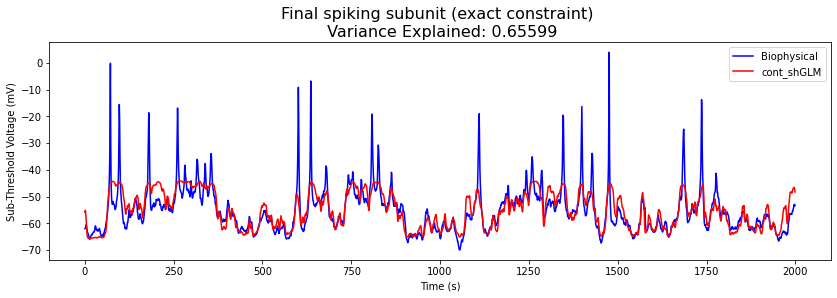

In [12]:
plt.figure(figsize = (14,4))
plt.plot(test_V_ref[:2000], label="Biophysical", c="blue")
plt.plot(test_V_final[:2000]-30, label="cont_shGLM", c="red")
print(np.corrcoef(test_V_ref, test_V_final)[0][1])


test_score = metrics.explained_variance_score(y_true=test_V_ref[:],
                                                      y_pred=test_V_final[:],
                                                      multioutput='uniform_average')

plt.title("Final spiking subunit (exact constraint) \n Variance Explained: " + str(round(test_score, 5)), fontsize = 16)
#plt.xticks(np.arange(0,8001,1000),[0,1,2,3,4,5,6,7,8])
#plt.xticks(np.arange(0,4001,1000),[0,1,2,3,4])
plt.xlabel("Time (s)")
plt.ylabel("Sub-Threshold Voltage (mV)")
plt.legend()
#plt.show()


#plt.savefig("/media/hdd01/sklee/cont_shglm/final_spike_absconstraint.png", dpi=150, bbox_inches='tight')#

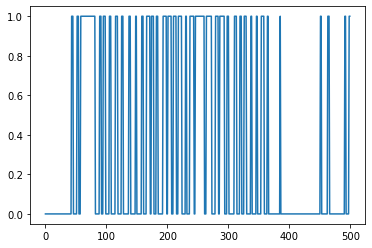

In [13]:
plt.plot(spikes[:500,1])
#print(spikes)


In [20]:
output_save = np.vstack((test_V_ref.reshape((1,-1)), test_V_final.reshape((1,-1))))
print(output_save.shape)
dend_save = raw.T
spikes_save = spikes.T
probs_save = probs.T
print(dend_save.shape)
print(spikes_save.shape)
print(probs_save.shape)

np.save("/media/hdd01/sklee/cont_shglm/gumbelS_test_V.npy", output_save)
np.save("/media/hdd01/sklee/cont_shglm/gumbelS_test_dend.npy", dend_save)
np.save("/media/hdd01/sklee/cont_shglm/gumbelS_test_spikes.npy", spikes_save)
np.save("/media/hdd01/sklee/cont_shglm/gumbelS_test_probs.npy", probs_save)

(2, 8000)
(4, 8000)
(4, 8000)
(4, 8000)


In [24]:
for name, param in model.named_parameters():
    print(name, param.data)

W_s_syn tensor([[[-0.0315,  0.0124],
         [ 0.0275, -0.0742]],

        [[ 0.0707, -0.0214],
         [-0.1790,  0.0427]],

        [[ 0.0133, -0.0499],
         [-0.0699, -0.1410]],

        [[-0.1436,  0.1785],
         [-0.0915, -0.2737]],

        [[-0.0181, -0.0938],
         [-0.0966, -0.0021]]], device='cuda:0')
W_ns_syn tensor([[[ 0.0180,  0.0316],
         [ 0.0033, -0.1436]],

        [[ 0.2122,  0.0589],
         [ 0.1388, -0.4086]],

        [[ 0.0892,  0.1097],
         [ 0.1188, -0.4102]],

        [[ 0.0962,  0.1005],
         [ 0.0819, -0.3779]],

        [[ 0.2436, -0.1203],
         [ 0.2005, -0.4056]]], device='cuda:0')
Tau_s_syn tensor([[-1.1390, -0.4341],
        [ 1.4416,  0.8805]], device='cuda:0')
Tau_ns_syn tensor([[-0.5424,  0.0030],
        [ 2.1495,  0.9492]], device='cuda:0')
Delta_s_syn tensor([[ 0.9353,  0.7619],
        [ 1.1066,  0.0250],
        [ 1.8560,  0.2394],
        [ 0.9058, -0.1134],
        [ 0.0638,  0.0154]], device='cuda:0')
Delta_ns_s